
# Comparing systematics and galaxy properties¶


This notebook serves as a validation test of the correlation between systematics and galaxy properties in Run 1.2i, based on the notebook contributed by Neha Joshi (@nehapjoshi) with Rachel Mandelbaum (@rmandelb)


In [72]:
import sys
sys.path.insert(-1, '/global/homes/z/zdu863/.conda/envs/py36/lib/python3.6/site-packages')

In [73]:
import healpy as hp
import numpy as np
import healsparse as hsp
import matplotlib.pyplot as plt

In [74]:
import GCRCatalogs
from GCR import GCRQuery

In [105]:
# print(GCRCatalogs.get_available_catalogs(False).keys())

In [92]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [98]:
source_cat = GCRCatalogs.load_catalog('dc2_source_run1.2i')

In [112]:
import re
print([c for c in object_cat.list_all_native_quantities() if re.search('ApFlux', c)])
print([c for c in object_cat.list_all_native_quantities() if re.search('apertureFlux', c)])

['slot_ApFlux_flag', 'slot_ApFlux_flag_apertureTruncated', 'slot_ApFlux_instFluxErr', 'slot_ApFlux_instFlux', 'slot_ApFlux_flag_sincCoeffsTruncated']
[]


In [76]:
#Define necessary cuts to galaxy properties:
properties_cuts = [
    GCRQuery('mag_i_cModel < %f'%25.5)
]

# Establish some basic cuts intended to yield a galaxy sample with reasonable flux measurements.
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects (primarily galaxies)
    GCRQuery((np.isfinite, 'mag_i_cModel')),  # Select objects that have i-band cmodel magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
]

In [79]:
#Define what properties we want to look at for the galaxy arrays:
quantities = ['ra', 'dec', 'mag_g_cModel', 'mag_i_cModel', 'mag_r_cModel', 'photoz_mode', 'x', 'y']

In [80]:
#Apply cuts to catalog and get the wanted sample:
data = object_cat.get_quantities(quantities,
                                 filters=basic_cuts+properties_cuts)

In [81]:
def plot_obs_data(obs_data, obs_title, obs_xaxis):
    min_obs, max_obs = np.percentile(obs_data,(1,99)) #cuts of first and ninety-ninth percentile to remove outliers
    nbins = 100
    myrange = [min_obs,max_obs]
    plt.title(obs_title)
    plt.hist(obs_data, nbins, range=myrange, histtype='step',
            linewidth=2.0, density=True)
    plt.xlabel(obs_xaxis)
    plt.yscale('log')
    
    quartiles = np.percentile(obs_data,(1,25,50,75,99))
    plt.axvline(quartiles[1])
    plt.axvline(quartiles[2])
    plt.axvline(quartiles[3])
    
    return quartiles

In [82]:
def plot_gal_data(gal_data, gal_title, gal_xaxis, obs_data, quartiles, name):
    nbins = 100
    min_gal, max_gal = np.percentile(gal_data,(1,99))
    labels = ['',
            '%s 1st quartile'%name,
             '%s 2nd quartile'%name,
             '%s 3rd quartile'%name,
             '%s 4th quartile'%name]
    
    myrange = [min_gal,max_gal]
    plt.title(gal_title)
    for q in range(1,len(quartiles)):
        data = gal_data[(obs_data<quartiles[q]) & (obs_data>=quartiles[q-1])]
        plt.hist(data, nbins, range=myrange, 
                 histtype='step', label=labels[q], linewidth=2.0, density=True)
    plt.legend(loc='upper right')
    plt.xlabel(gal_xaxis)
    plt.yscale('log')

In [83]:
b = 'i' #band name
hsp_mp = hsp.HealSparseMap.read('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.2i/sysmaps/allmaps-%s.fits'%b) #Read the systematics maps
ra = data['ra']; dec = data['dec'];
obs_values = hsp_mp.getValueRaDec(ra, dec) #Get the systematics at the postition of each object

In [84]:
gr = data['mag_g_cModel'] - data['mag_r_cModel']
ri = data['mag_r_cModel'] - data['mag_i_cModel']

In [89]:
obs_titles = ['nvisit','airmass','rawSeeing','finSeeing','bg_mean','bg_var'] #name of the systematics
obs_data = [obs_values[obs_title] for obs_title in obs_titles]

gal_titles = ['g-r cmodel color', 'r-i cmodel color', 'i-band cmodel magnitude']
gal_data = [gr, ri, data['mag_i_cModel']]

obs_xaxis = ['', '', '', '', '','']
gal_xaxis = ['g-r color', 'r-i color', 'i mag']

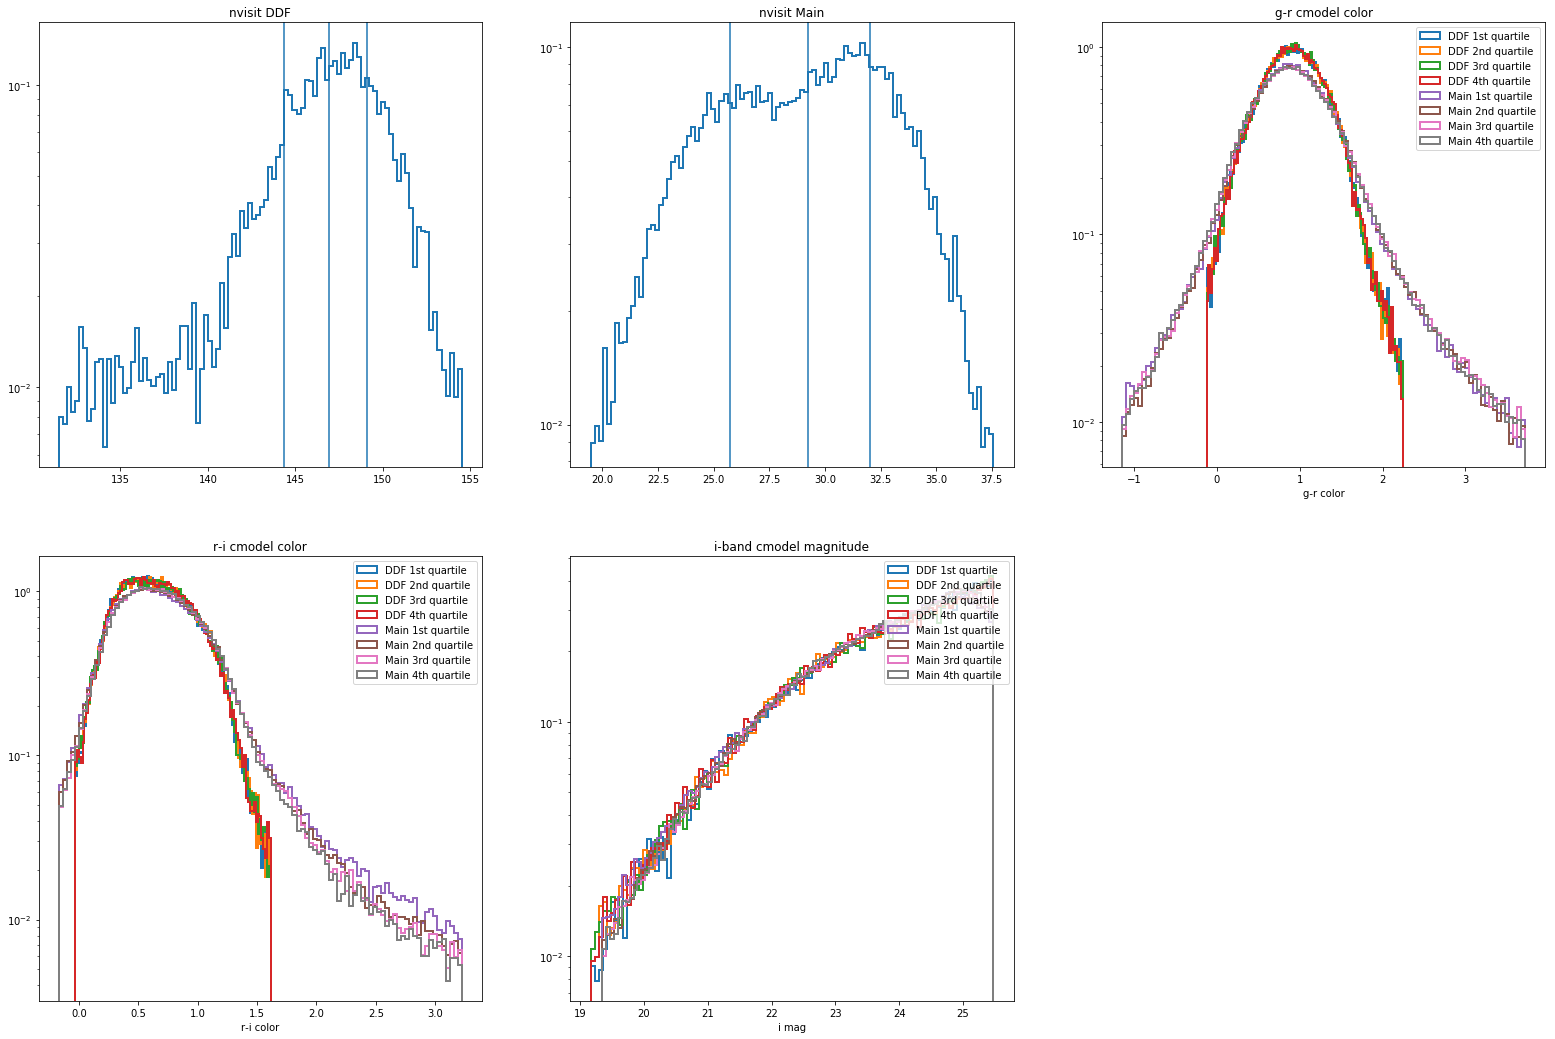

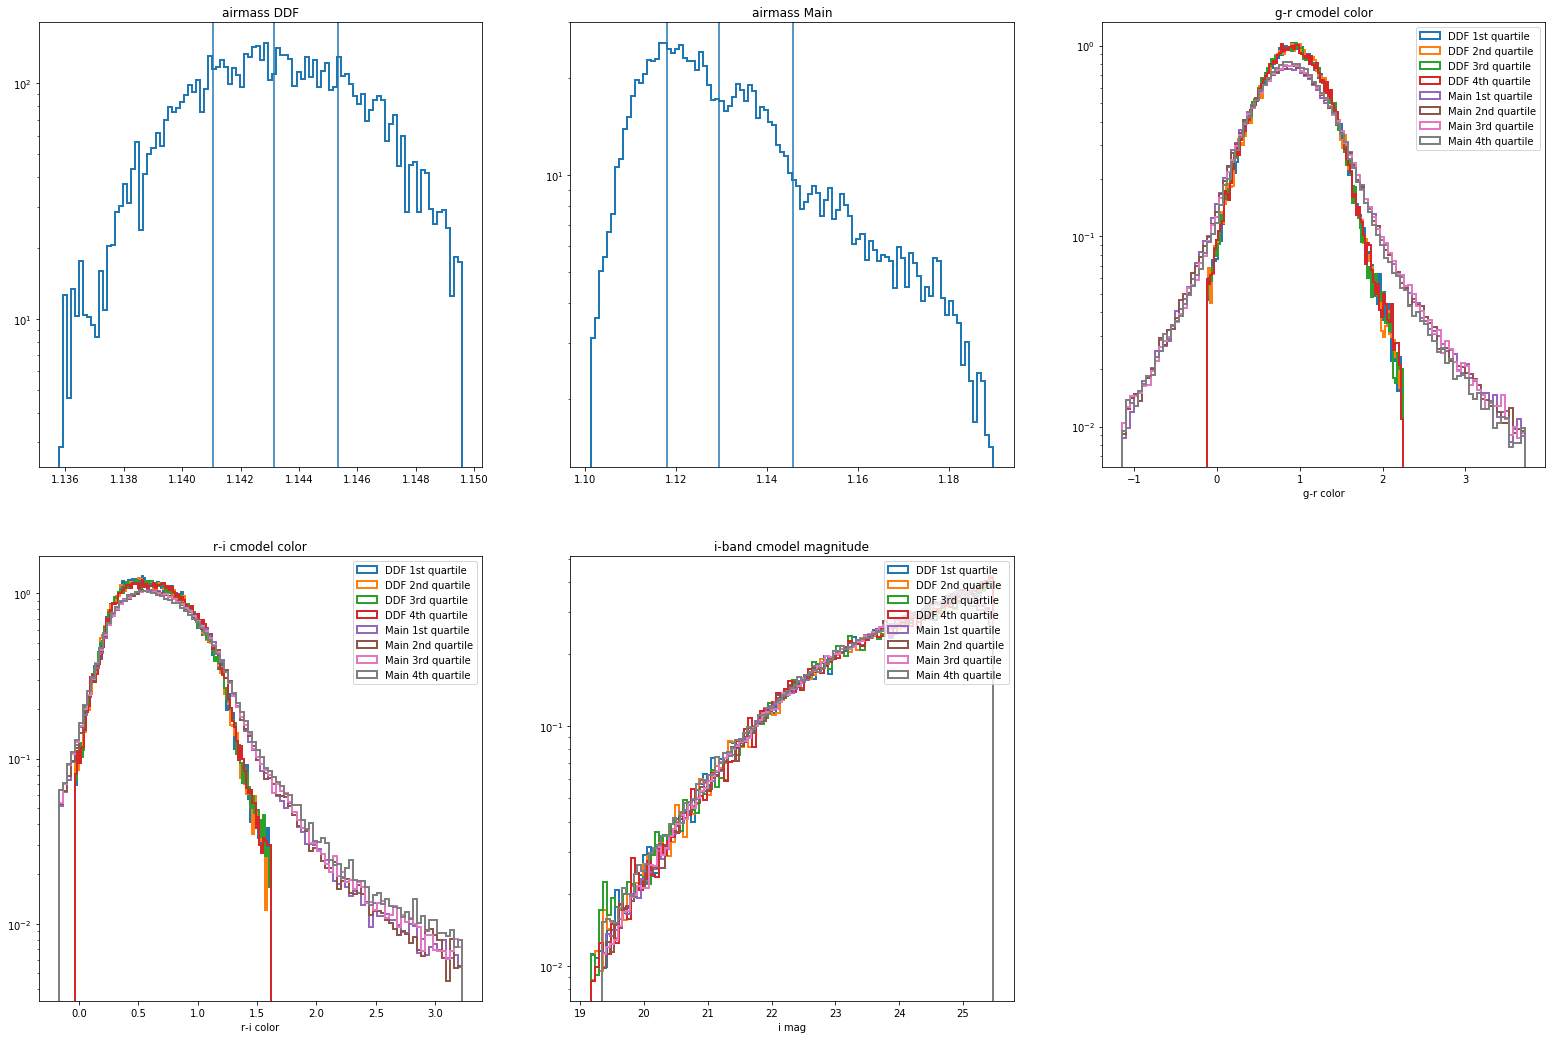

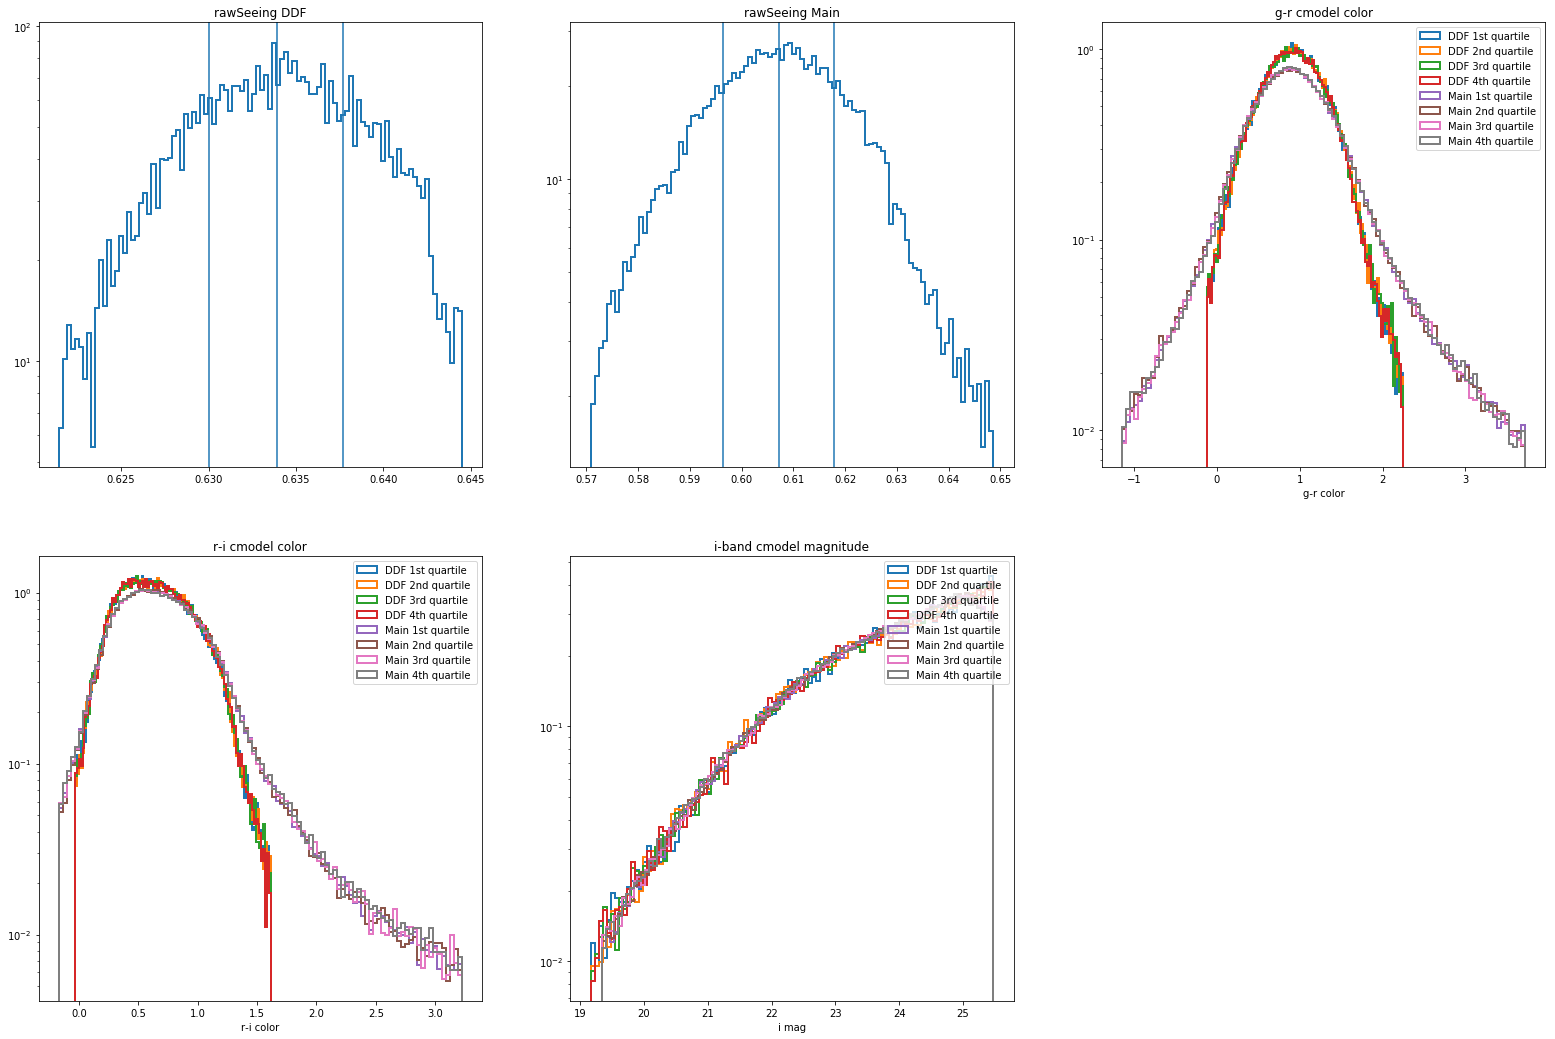

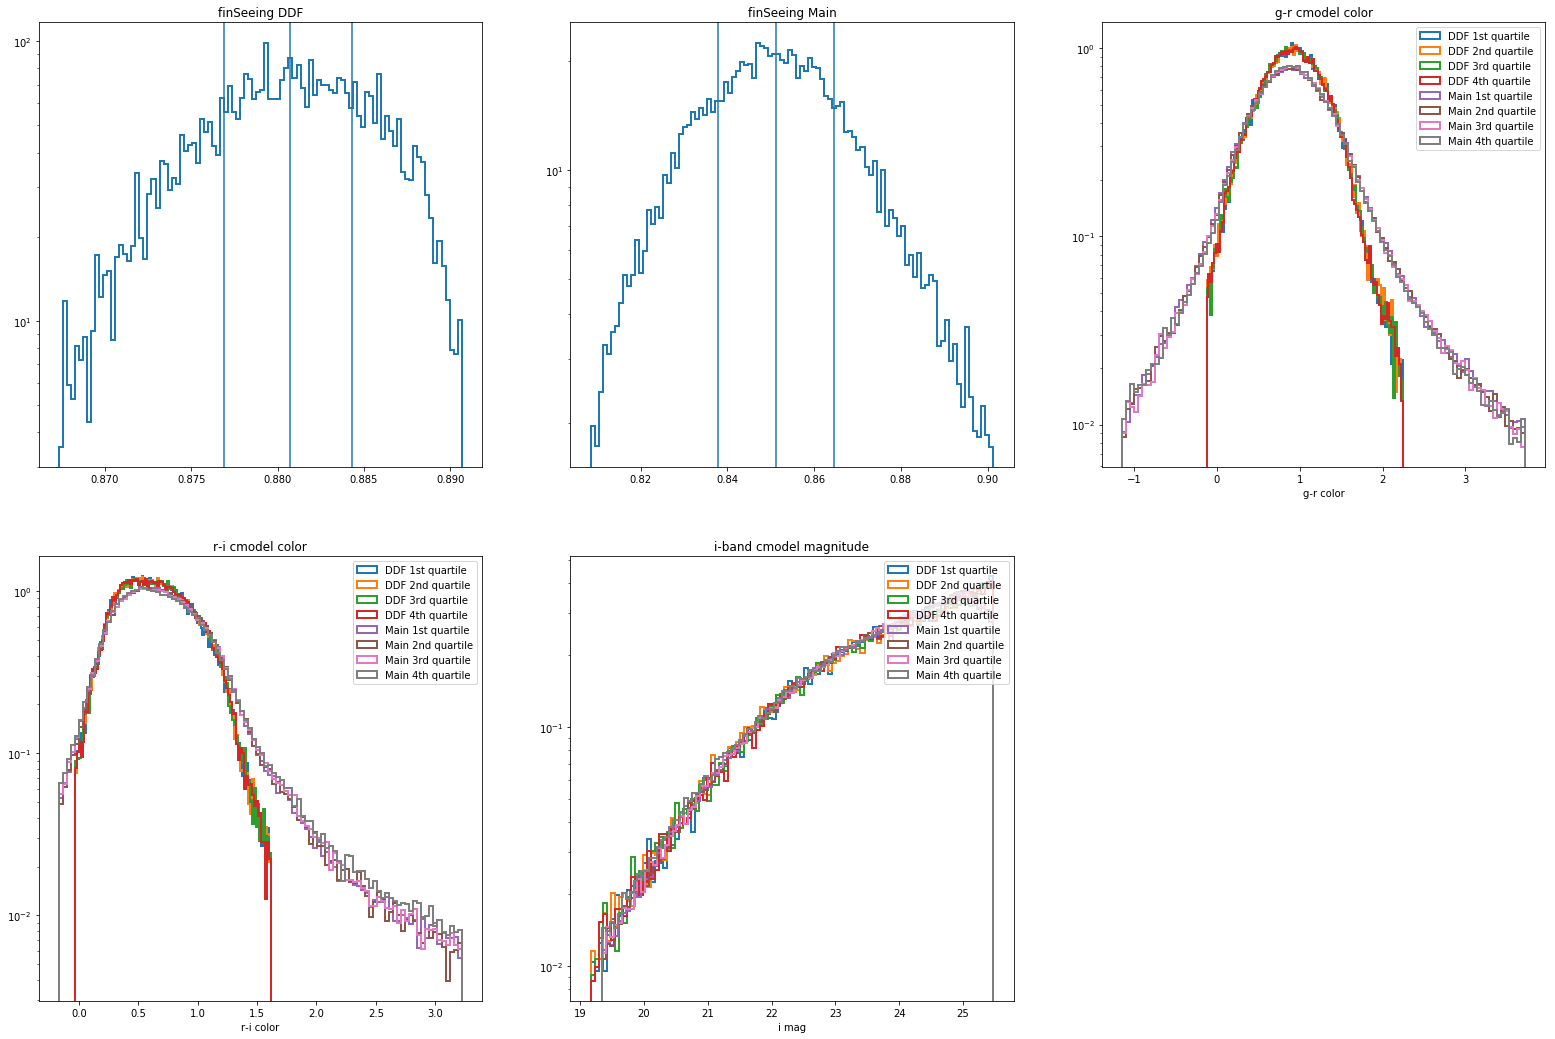

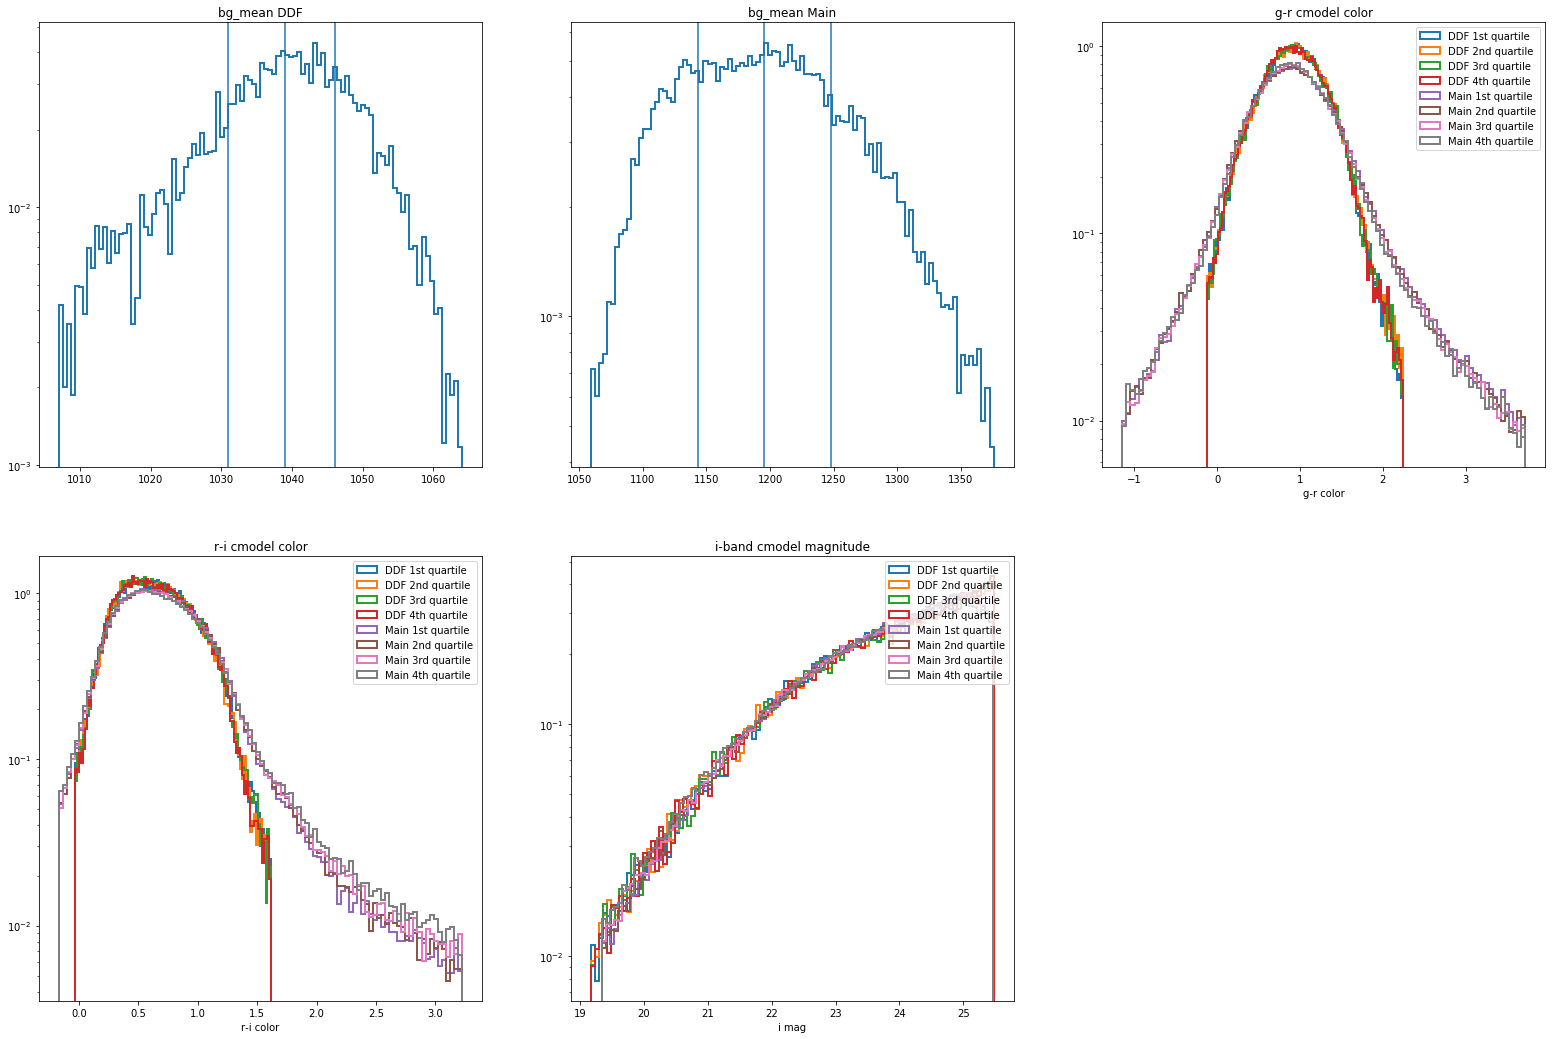

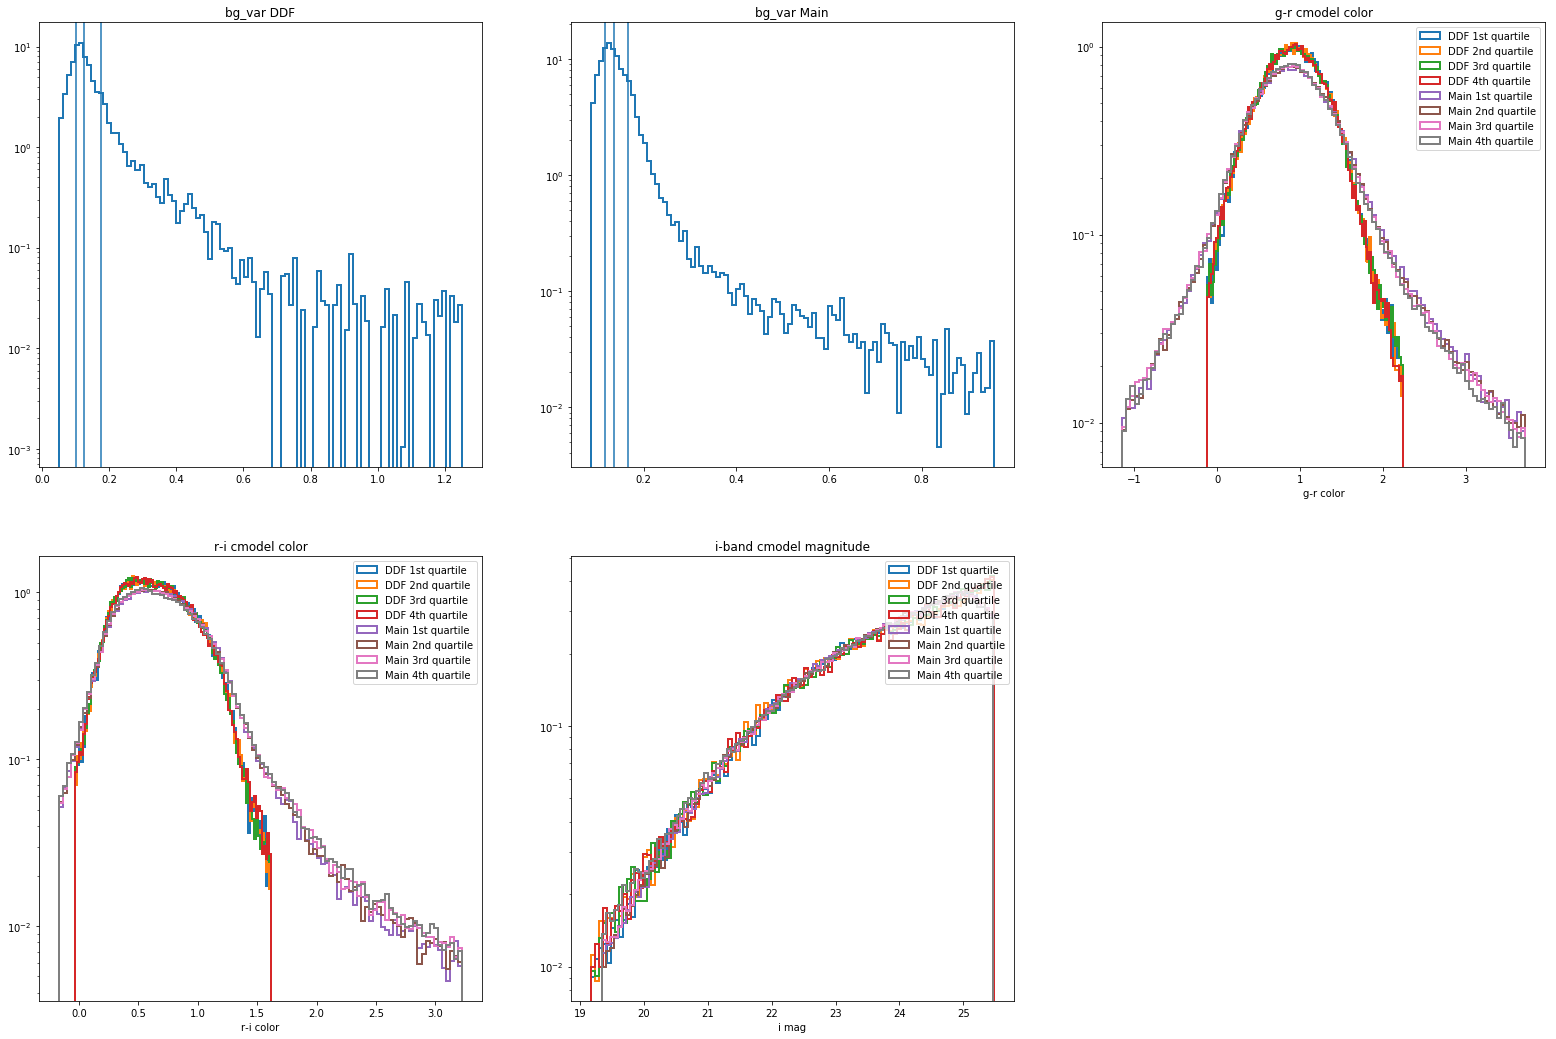

In [91]:
for obs in range(len(obs_data)):
    good_data = ~np.isnan(obs_data[obs]) & ~(obs_data[obs]<-99999)
    good_data_ddf = good_data & (obs_values['nvisit']>130)   #DDF
    good_data_noddf = good_data & (obs_values['nvisit']<40) & (obs_values['nvisit']>=0)   #remove DDF

    plt.figure(figsize=(27,18))
    
    #plotting systematics data (inside & outside DDF)
    plt.subplot(231)
    quartiles1 = plot_obs_data(obs_data[obs][good_data_ddf], obs_titles[obs]+' DDF', obs_xaxis[obs])
    plt.subplot(232)
    quartiles2 = plot_obs_data(obs_data[obs][good_data_noddf], obs_titles[obs]+' Main', obs_xaxis[obs])
    for gal in range(len(gal_data)):
        good_data_ddf = good_data_ddf & ~np.isnan(gal_data[gal])
        good_data_noddf = good_data_noddf & ~np.isnan(gal_data[gal])
        
        #plotting galaxy data
        plt.subplot(2,3,gal+3)
        plot_gal_data(gal_data[gal][good_data_ddf], gal_titles[gal], gal_xaxis[gal], obs_data[obs][good_data_ddf], quartiles1, 'DDF')
        plot_gal_data(gal_data[gal][good_data_noddf], gal_titles[gal], gal_xaxis[gal], obs_data[obs][good_data_noddf], quartiles2, 'Main')
    
    plt.savefig(obs_titles[obs],dpi=200)